# Project Title
### Data Engineering Capstone Project

#### Project Summary

The aim of this project is to analyse data of immigration to the United States in addition to integrate with supplementary data which include airport codes, U.S. city demographics, and temperature data to extract insights focusing on the type of visas being issued.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
#!pip install pyspark

In [2]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql.functions import col,isnan, when, count,to_date
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark import SparkContext

import os 
import sys

from pyspark.sql.functions import udf
import datetime as dt

import configparser
import matplotlib.pyplot as plt 


### Step 1: Scope the Project and Gather Data

#### Scope 
The scope is to develop ETL pipelines using spark to stage data to S3 storage, and load to Redshift database and define efficient data models star schema.

#### Describe and Gather Data 

In this project, we'll work with four datasets to complete the project:

- I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from. Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
- World Temperature Data: This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- U.S. City Demographic Data: This dataset contains information about the demographics of all US cities. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).

__Datasets descriptions__:


__immegration dataset:__


| Column Name | Description |
| :--- | :--- |
| CICID* | ID that uniquely identify one record in the dataset |
| I94YR | 4 digit year |
| I94MON | Numeric month |
| I94CIT | 3 digit code of source city for immigration (Born country) |
| I94RES | 3 digit code of source country for immigration (Residence country) |
| I94PORT | Port addmitted through |
| ARRDATE | Arrival date in the USA |
| I94MODE | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported) |
| I94ADDR | State of arrival |
| DEPDATE | Departure date from the USA |
| I94BIR | Age of Respondent in Years |
| I94VISA | Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student) |
| COUNT | Used for summary statistics |
| DTADFILE | Character Date Field |
| VISAPOST | Department of State where Visa was issued |
| OCCUP | Occupation that will be performed in U.S. |
| ENTDEPA | Arrival Flag. Whether admitted or paroled into the US |
| ENTDEPD | Departure Flag. Whether departed, lost visa, or deceased |
| ENTDEPU | Update Flag. Update of visa, either apprehended, overstayed, or updated to PR |
| MATFLAG | Match flag |
| BIRYEAR | 4 digit year of birth |
| DTADDTO | Character date field to when admitted in the US (allowed to stay until) |
| GENDER | Gender |
| INSNUM | INS number |
| AIRLINE | Airline used to arrive in U.S. |
| ADMNUM | Admission number, should be unique and not nullable |
| FLTNO | Flight number of Airline used to arrive in U.S. |
| VISATYPE | Class of admission legally admitting the non-immigrant to temporarily stay in U.S. |

__World Temperature Data:__
| Column Name | Description |
| :--- | :--- |
| dt | Date in format YYYY-MM-DD |
| AverageTemperature | Average temperature of the city in a given date |
| City | City Name |
| Country | Country Name |
| Latitude | Latitude |
| Longitude | Longitude |

__Airport Code Table:__

| Column Name | Description |
| :--- | :--- |
| ident | Unique identifier |
| type | Type of the airport |
| name | Airport Name |
| elevation_ft | Altitude of the airport |
| continent | Continent |
| iso_country | ISO code of the country of the airport |
| iso_region | ISO code for the region of the airport |
| municipality | City where the airport is located |
| gps_code | GPS code of the airport |
| iata_code | IATA code of the airport |
| local_code | Local code of the airport |
| coordinates | GPS coordinates of the airport |

__US Demographoics:__

| Column Name | Description |
| :--- | :--- |
| City | Name of the city |
| State | US state of the city |
| Median Age | The median of the age of the population |
| Male Population | Number of the male population |
| Female Population | Number of the female population |
| Total Population | Number of the total population |
| Number of Veterans | Number of veterans living in the city |
| Foreign-born | Number of residents of the city that were not born in the city |
| Average Household Size | Average size of the houses in the city |
| State Code | Code of the state of the city |
| Race | Race class |
| Count | Number of individual of each race |

In [3]:
#Create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:3.0.0-s_2.12")\
.config("spark.driver.memory", "12g") \
.enableHiveSupport().getOrCreate()
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [4]:
#write to parquet
#df_spark.write.parquet("data/sas_data")
immigration_df=spark.read.parquet("data/sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [5]:
#immegration dataset
immigration_df.printSchema()
immigration_df.show(5)

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [6]:
#find percentage of null values in columns
nulls_df = immigration_df.select([(count(when(isnan(c) | col(c).isNull(), c))/immigration_df.count()*100) \
                                  .alias(c) for c in immigration_df.columns]).collect()

<BarContainer object of 28 artists>

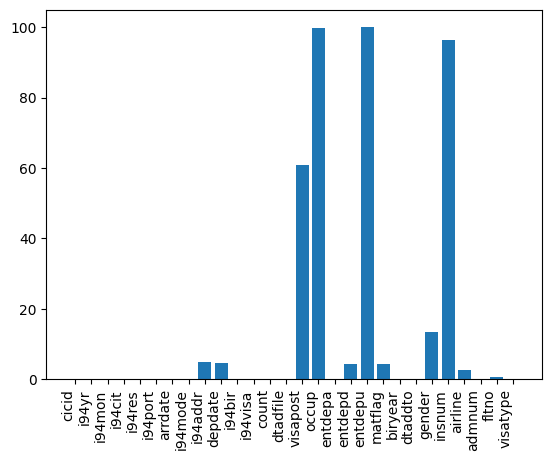

In [7]:
nulls_df = spark.createDataFrame(nulls_df).toPandas()
plt.xticks(rotation=90, ha='right')
plt.bar(nulls_df.columns, nulls_df.values.tolist()[0])

In [8]:
#From the plot, we can see high percentage null values columns, ['visapost', 'occup','entdepu','insnum', 'fltno']
#drop columns with more then 60% nulls (visapost, occup,entdepu,insnum, fltno)
drop_list = ['visapost', 'occup','entdepu','insnum', 'fltno']
immigration_df = immigration_df.drop(*drop_list)

In [9]:
#Drop not needs columns
no_needs_col = ["count", "entdepa", "entdepd", "matflag", "dtaddto", "biryear", "admnum"]
immigration_df = immigration_df.drop(*no_needs_col)

immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- visatype: string (nullable = true)



In [10]:
immigration_df.show()

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+--------+------+-------+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|dtadfile|gender|airline|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+--------+------+-------+--------+
|5749531.0|2016.0|   4.0| 251.0| 251.0|    NYC|20574.0|    1.0|     NV|20579.0|  42.0|    1.0|20160430|     F|     DL|      B1|
|5749532.0|2016.0|   4.0| 251.0| 251.0|    NYC|20574.0|    1.0|     NV|20584.0|  40.0|    2.0|20160430|     F|     DL|      B2|
|5749533.0|2016.0|   4.0| 251.0| 251.0|    NYC|20574.0|    1.0|     NV|20584.0|  39.0|    2.0|20160430|     M|     DL|      B2|
|5749538.0|2016.0|   4.0| 251.0| 251.0|    NYC|20574.0|    1.0|     NY|   NULL|  23.0|    2.0|20160430|     M|     EK|      B2|
|5749540.0|2016.0|   4.0| 251.0| 251.0|    NYC|20574.0|    1.0|     NY|20575.0|  39.0|    2.0|20160430| 

In [11]:
#find and drop duplicates
immigration_df.exceptAll(immigration_df.dropDuplicates(['cicid'])).show()
#No duplicate was found

+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+--------+------+-------+--------+
|cicid|i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|dtadfile|gender|airline|visatype|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+--------+------+-------+--------+
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+--------+------+-------+--------+



Analyse World Temperature Data

In [12]:
#World Temperature Data
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
#df = pd.read_csv(fname)
temperature_df = spark.read.option("header", True).csv(fname)

In [13]:
#Explore Data
temperature_df.printSchema()
temperature_df.show(5)

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              NU

In [14]:
#Aggregate data by Country, we wil take average tempreture 
temperature_df = temperature_df.groupBy(["Country"]) \
    .agg(F.avg("AverageTemperature").alias('AverageTemperature'),F.first("Latitude").alias('Latitude'), \
         F.first("Longitude").alias('Longitude'))

# change Country to upper case
temperature_df = temperature_df.withColumn('Country', F.upper(temperature_df.Country))


In [15]:
temperature_df.show()

+--------------------+------------------+--------+---------+
|             Country|AverageTemperature|Latitude|Longitude|
+--------------------+------------------+--------+---------+
|         AFGHANISTAN| 13.81649689626358|  36.17N|   69.61E|
|             ALBANIA|15.525828490208466|  40.99N|   19.17E|
|             ALGERIA|17.763205946291574|  36.17N|    3.98E|
|              ANGOLA|21.759715773235634|  12.05S|   13.15E|
|           ARGENTINA|16.999215885618394|  39.38S|   62.43W|
|             ARMENIA| 8.375597043951773|  40.99N|   44.73E|
|           AUSTRALIA| 16.70146214247645|  34.56S|  138.16E|
|             AUSTRIA| 6.285928363866069|  47.42N|   15.39E|
|          AZERBAIJAN| 11.11366381418095|  40.99N|   48.99E|
|             BAHAMAS| 24.78697831775695|  24.92N|   78.03W|
|             BAHRAIN| 25.85560129096327|  26.52N|   50.15E|
|          BANGLADESH| 25.05251222557483|  23.31N|   90.00E|
|             BELARUS|6.1422531980416935|  52.24N|   23.65E|
|             BELGIUM| 9

U.S. City Demographic Data

In [16]:
#explore U.S. City Demographic Data
us_demographics_df = spark.read.csv('data/us-cities-demographics.csv', sep=';', inferSchema=True, header=True)
us_demographics_df.printSchema()
us_demographics_df.show()



root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)

+--------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+------+
|          City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race| Count|
+--------------+-------------+----------+---------------+-----------------+----------------+

In [17]:
def cast_totype(df, cols, type):
    for c in cols:
        df = df.withColumn(c, df[c].cast(type))
    return df

In [18]:
#change datatypes for count columns
int_cols = ['Count', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born']
float_cols = ['Median Age', 'Average Household Size']

us_demographics_df = cast_totype(us_demographics_df, int_cols, IntegerType())
us_demographics_df = cast_totype(us_demographics_df, float_cols, DoubleType())


In [19]:
#aggregate by City", "State", "State Code 
us_demographics_df = us_demographics_df.groupBy(["City", "State", "State Code"]) \
    .agg(F.first("Median Age").alias('median_age'),F.first("Male Population").alias('male_population'), \
         F.first("Female Population").alias('female_population'),F.first("Total Population").alias('total_population'))
    
us_demographics_df.show()

+---------------+--------------+----------+----------+---------------+-----------------+----------------+
|           City|         State|State Code|median_age|male_population|female_population|total_population|
+---------------+--------------+----------+----------+---------------+-----------------+----------------+
|    Jersey City|    New Jersey|        NJ|      34.3|         131765|           132512|          264277|
|      Rockville|      Maryland|        MD|      38.1|          31205|            35793|           66998|
|   Delray Beach|       Florida|        FL|      47.9|          32219|            34042|           66261|
| Urban Honolulu|        Hawaii|        HI|      41.4|         176807|           175959|          352766|
|     Cincinnati|          Ohio|        OH|      32.7|         143654|           154883|          298537|
|       Gulfport|   Mississippi|        MS|      35.1|          33108|            38764|           71872|
|       Alhambra|    California|        CA|   

Airport Code Data

In [20]:
#Airport Code Data
airport_codes_df = spark.read.csv('data/airport-codes_csv.csv', sep=',', inferSchema=True, header=True)
airport_codes_df.printSchema()
airport_codes_df.show()


root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|   

In [21]:
i94date_df =immigration_df.select(col('arrdate').alias('arrival_sasdate')).dropDuplicates()
get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)

i94date_df = i94date_df.withColumn("arrival_date", get_datetime(i94date_df.arrival_sasdate))
i94date_df = i94date_df.withColumn('arrival_month',F.month(i94date_df.arrival_date))
i94date_df = i94date_df.withColumn('arrival_year',F.year(i94date_df.arrival_date))
i94date_df = i94date_df.withColumn('arrival_day',F.dayofmonth(i94date_df.arrival_date))
i94date_df = i94date_df.withColumn('day_of_week',F.dayofweek(i94date_df.arrival_date))
i94date_df = i94date_df.withColumn('arrival_weekofyear',F.weekofyear(i94date_df.arrival_date))
i94date_df.printSchema()

root
 |-- arrival_sasdate: double (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- arrival_weekofyear: integer (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
![Database schema](img\schema.png)

The conceptual model contains:
1. Fact table : contains immigration data .
2. Dimension tables for countries of migrant residence and average temperature, us demographics continas US state demographics information, i94visa mapped to id, and calendar data.
#### 3.2 Mapping Out Data Pipelines
The pipeline steps are as follows:

1. Load i94 immigration dataset.
2. clean immigration data and create immigration fact table.
3. create i94vis dim table.
4. Load global tempreture data.
5. Load countries data and mapped country to average tempreture.
6. create countries dim table.
7. load us demographic data.
8. create us demographics dim.
9. create calendar dim table.



### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [22]:
# Write code here
from etl import *

immigration_df, i49visa_df, demographics_df, countries_df, calendar_df = run_pipeline()


+---+--------+
|vid|visatype|
+---+--------+
|  1|Business|
|  2|Pleasure|
|  3| Student|
+---+--------+

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = tru

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [23]:
# Perform quality checks here
from helper_functions import *

table_dfs = {
    'immigration_fact': immigration_df,
    'i49visa_dim': i49visa_df,
    'demographics_dim': demographics_df,
    'countries_dim': countries_df,
    'calendar_dim': calendar_df
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    quality_checks(table_df, table_name)

Data quality check passed for immigration_fact, available records counts: 3096313 
Data quality check passed for i49visa_dim, available records counts: 3 
Data quality check passed for demographics_dim, available records counts: 596 
Data quality check passed for countries_dim, available records counts: 289 
Data quality check passed for calendar_dim, available records counts: 30 


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
Technology used for this projects:
1. Apache Spark used for large-scale data processing with high speed processing time.
2. Amazon S3 used to store staged data on the cloud
* Propose how often the data should be updated and why.  
The proposed update time should be monthly, as data of immegrations devided monthly.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.  
Spark very effecient when dealing with high volum datasets. also we can use partitioning functionality by month.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.  
In this case, Apache Airflow will be used to schedule and run data pipelines at proposed times.
 * The database needed to be accessed by 100+ people.  
Data will be stored in Amazon redshift database. and different users with diffirent access roles should be created.